In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np


import sys
sys.path.append("..")

This notebook contains code demonstrating how to do regression.
- Linear regression
- Fitting a spike train with a renewal process GP
- Computing the renewal process likelihood landscape
- Performing GPLVM on a biological data for dimensionality reduction

In [4]:
import neuroppl as nppl
import neuroppl.utils as utils

dev = utils.pytorch.get_device() # PyTorch device, gpu 0 by default if available

PyTorch version: 1.7.1+cu101
Using device: cuda:0


### Kernel regression and splines
https://www.ics.uci.edu/~welling/classnotes/papers_class/Kernel-Ridge.pdf. The choice of kernel implicitly selects the basis functions selected for kernel expansion. With a polynomial basis, we can fit Lagrange polynomials.

In [ ]:
x = np.random.randn(2)
y = np.random.randn(1, 2) + 4.
def phi(x):
    x = x[None, :]
    return np.concatenate((np.ones_like(x), x, x**2, x**3, x**4, x**5, x**6, x**7, x**8), axis=0)

w, f = utils.signal.basis_function_regression(x, y, phi, lambd=0.)

x_eval = np.linspace(x.min(), x.max(), 100)
ph = phi(x_eval)[None, ...] # o, d, n
f = (w[..., None]*ph).sum(1) # o, n

plt.plot(x_eval, f[0, :])
plt.scatter(x, y[0, :])
plt.show()

In [ ]:
x = torch.linspace(0, 6, 7)
y = x.sin()
xs = torch.linspace(0, 6, 101)

spline = utils.signal.spline_interpolate(3)

ys = spline.interp(x, y, xs)
Ys = spline.integ(x, y, xs)

plt.scatter(x, y, label='Samples', color='purple')
plt.plot(xs, ys, label='Interpolated curve')
plt.plot(xs, xs.sin(), '--', label='True Curve')
plt.plot(xs, Ys, label='Spline Integral')
plt.plot(xs, 1-xs.cos(), '--', label='True Integral')
plt.legend()
plt.show()

In [ ]:
linn = utils.signal.linear_interpolate(x.numpy(), y.numpy(), xs.numpy())
plt.plot(xs.numpy(), linn)
plt.scatter(x.numpy(), y.numpy())

### SVGP
We use sparse kernel methods to fit kernel regression and get uncertainty estimates.

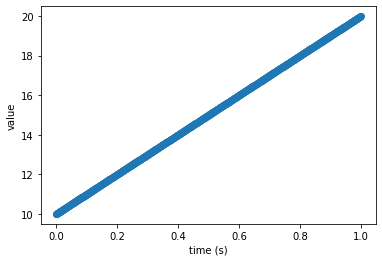

In [10]:
tbin = 1. # rate = output ratio
steps = 1000
max_time = tbin*steps*0.001
y_dims = 1
in_dims = 1

rate = np.empty((y_dims, steps))
rate[0] = 0.01*np.arange(steps) + 10.
y = rate + 2.*np.random.randn(y_dims, steps)

cov = np.arange(steps)*tbin*0.001 # time points to evaluate

plt.scatter(cov, rate[0])
plt.xlabel('time (s)')
plt.ylabel('value')
plt.show()

In [20]:
v = 1.*torch.ones(y_dims)

#('linear', 'euclid', np.empty((1, y_dim)))]
                  #('polynomial', 'euclid', np.zeros(y_dim), 2)]
                  #('RBF', 'euclid', np.ones((1, y_dim)))]
                  #('Matern32', 'euclid', np.ones((1, y_dim)))]
                  #('RQ', 'euclid', np.ones((1, y_dim)), np.ones(y_dim))]
    


constraints = []
krn_1 = nppl.kernels.kernel.Constant(variance=v, tensor_type=torch.float)
krn_2 = nppl.kernels.kernel.Linear(
    input_dims=in_dims, 
    track_dims=[0], tensor_type=torch.float
)

kernel = nppl.kernels.kernel.Product(krn_1, krn_2)

num_induc = 8
Xu = torch.tensor(
    [np.linspace(0, max_time, num_induc)]
).T[None, ...].repeat(y_dims, 1, 1)
inducing_points = nppl.kernels.kernel.inducing_points(y_dims, Xu, constraints)



input_data = [torch.from_numpy(cov)]

In [21]:
# mapping
in_dims = Xu.shape[-1]

gpr = nppl.mappings.GP.SVGP(
    in_dims, y_dims, kernel, inducing_points=inducing_points, 
    whiten=True, jitter=1e-4, mean=torch.zeros(y_dims), learn_mean=True
)

In [22]:
### inputs and likelihood ###
input_group = nppl.inference.input_group()
input_group.set_XZ(input_data, steps, batch_info=500)


likelihood = nppl.likelihoods.Gaussian(y_dims, 'exp', log_var=torch.zeros(y_dims))
likelihood.set_Y(torch.from_numpy(y), batch_info=500) 


glm = nppl.inference.VI_optimized(input_group, gpr, likelihood)
glm.to(dev)

VI_optimized(
  (input_group): input_group()
  (mapping): SVGP(
    (kernel): Product(
      (kern0): Constant()
      (kern1): Linear()
    )
    (induc_pts): inducing_points()
  )
  (likelihood): Gaussian()
)

In [23]:
# fitting
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 100, sch)
opt_lr_dict = {'default': 5*1e-3}

glm.set_optimizers(opt_tuple, opt_lr_dict)

annealing = lambda x: 1.0
losses = glm.fit(3000, loss_margin=0.0, margin_epochs=100, kl_anneal_func=annealing, 
                 cov_samples=1, ll_samples=10, ll_mode='MC')

plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('NLL per time sample')
plt.show()

ValueError: Loss diverged

In [ ]:
def posterior_rate(mapping, likelihood, covariates, MC, F_dims, trials=1, percentiles=[0.05, .5, 0.95]):
    """
    Sample F from diagonalized variational posterior.
    
    :returns: F of shape (MCxtrials, outdims, time)
    """
    cov = mapping.to_XZ(covariates, trials)
    with torch.no_grad():
        if mapping.MC_only:
            F = mapping.sample_F(cov)[:, F_dims, :] # TODO: cov_samples vs ll_samples?
            samples = likelihood.f(F.view(-1, trials, *samples.shape[1:]))
        else:
            F_mu, F_var = mapping.compute_F(cov)
            samples = likelihood.sample_rate(
                F_mu[:, F_dims, :], F_var[:, F_dims, :], trials, MC)
    
    return utils.signal.percentiles_from_samples(samples, percentiles)

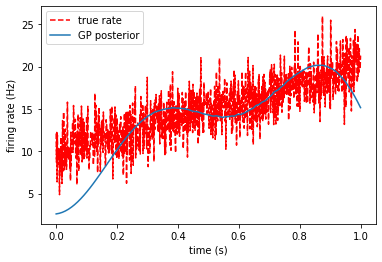

In [26]:
# compare to true rate
steps= 100
show_neurons = [0]
covariates = [np.linspace(0.0, max_time, steps)]

mean = rate_model.eval_rate(covariates, show_neurons, True)
for k, neuron in enumerate(show_neurons):
    
    fig, ax = plt.subplots()
    
    ax.plot(np.linspace(0, max_time, rate.shape[1]), rate[neuron], 'r--', label='true rate')
    line, = ax.plot(covariates[0], mean[k], label='model fit')
    #ax.fill_between(
    #    covariates[0], lower[k],
    #    upper[k], color=line.get_color(), alpha=0.5
    #)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('firing rate (Hz)')
    ax.legend()
    
plt.show()

### Spike train GP
Here we fit several trials of an inhomogenous Poisson process GP to a spike train. To improve optimization, we use the natural gradient.

In [ ]:
tbin = 0.001
steps = 1000
max_time = tbin*steps
trials = 10
neurons = 2

rate = np.empty((trials, neurons, steps))
rate[:, 0, :] = (20.0*np.sin(2*np.pi*np.arange(steps)/1000) + 20.0)[None, :].repeat(trials, axis=0)
rate[:, 1, :] = (20.0*np.cos(2*np.pi*np.arange(steps)/1000) + 20.0)[None, :].repeat(trials, axis=0)

spikes = mdl.point_process.gen_IPP(rate, tbin) # generate spike trains

times = np.arange(steps)*tbin # time points to evaluate
covariates = times[None, :, None].repeat(trials, axis=0) # input regressors of shape (trials, time, dimensions)

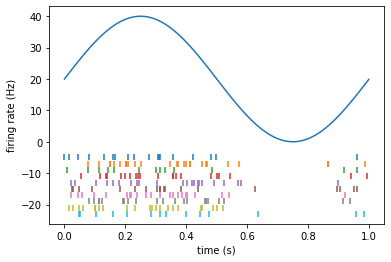

In [41]:
visualize_neuron = 0

t_spike = []
for t in range(trials):
    t_spike.append(neural_utils.BinToTrain(spikes[t, visualize_neuron]))

plt.plot(times, rate[0, visualize_neuron])
for n in range(trials):
    plt.scatter(t_spike[n]*tbin, (-5.0-2*n)*np.ones_like(t_spike[n]), marker='|')
plt.xlabel('time (s)')
plt.ylabel('firing rate (Hz)')
plt.show()

In [91]:
l = 0.1*np.ones((1, neurons)) # shape (input dimensions, output dimensions)
v = 1.*np.ones(neurons) # shape (output dimensions,)
kernels_tuples = [('variance', v), 
                  ('RBF', 'euclid', l)]
VI_tuples = [(None, None, None, 1)] # prior, var. dist., topology, dimensions

num_induc = 8
indps = np.linspace(0, max_time, num_induc)
inducing_points = indps[None, :, None].repeat(neurons, axis=0) # shape (output dims, time, input dims)

rate_model = neuroprob.nonparametrics.Gaussian_process(
    neurons, # number of neurons
    inducing_points, # initial inducing points                                          
    kernels_tuples, # kernels                                          
    VI_tuples, # priors and variational distributions                                          
    shared_kernel_params=False, # share all kernel parameters over output dims?                                          
    cov_type='factorized', # fit with full GP posterior covariance?                                          
    mean=np.zeros((neurons)), # initial GP mean
    inv_link='exp', # inverse link function
    kern_f='softplus' # kernel inverse link
)

rate_model.set_params(
    tbin, # time bin
    jitter=1e-5 # jitter (numerical stability)
)

In [92]:
# likelihood model
likelihood = neuroprob.likelihoods.Poisson(
    neurons, # number of neurons or output dimensions
    'exp' # inverse link function
)

likelihood.set_params(tbin, jitter=1e-5)

In [93]:
# put together in GLM framework
glm = neuroprob.inference.VI_optimized([rate_model], likelihood)
glm.preprocess(
    [covariates], # list of input regressors of GP
    covariates.shape[1], # number of timesteps in total
    spikes, # spike trains
    batch_size=1000 # batch size (over timesteps)
)
    
glm.to(dev) # move to GPU if available

nll_optimized(
  (likelihood): Poisson()
  (rate_model): ModuleList(
    (0): Gaussian_process(
      (kernel): Product(
        (kern0): Constant()
        (kern1): RBF()
      )
    )
  )
)

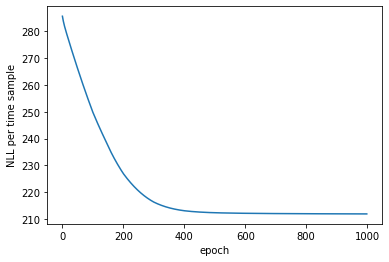

In [94]:
# fitting
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (
    optim.Adam, # optimizer
    100, # scheduler time steps for iteration
    sch # scheduler effect
)
opt_lr_dict = {'default': 1e-2}

glm.set_optimizers(
    opt_tuple, 
    opt_lr_dict, 
    nat_grad=('rate_model.0.u_loc', 'rate_model.0.u_scale_tril'), 
    nat_lr=1e-1
    #newton_grad=('rate_model.0.u_loc',), 
    #newton_lr=1e-1
)

annealing = lambda x: 1.0
losses = glm.fit(
    1000, # number of max iterations
    loss_margin=0e0, 
    stop_iters=100, 
    anneal_func=annealing, 
    cov_samples=trials, # need to put in trials as we are doing regression over trials 
    ll_samples=20, 
    ll_mode='MC',
    bound='ELBO'
)

plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('NLL per time sample')
plt.show()

In [6]:
# compare to true rate
steps= 100
show_neurons = [0, 1]
eval_times = np.linspace(0.0, max_time, steps)[None, :] # shape (dims, timesteps)

lower, mean, upper = rate_model.eval_rate(eval_times, show_neurons, 'posterior')

visualize_trial = 0
fig, axes = plt.subplots(1, 2)
for k, neuron in enumerate(show_neurons):
    
    ax = axes[k]
    ax.plot(np.linspace(0, max_time, rate.shape[-1]), rate[visualize_trial, neuron], 'r--', label='true rate')
    line, = ax.plot(eval_times[0], mean[k], label='GP posterior')
    ax.fill_between(
        eval_times[0], lower[k],
        upper[k], color=line.get_color(), alpha=0.5
    )
    ax.set_xlabel('time (s)')
    ax.set_ylabel('firing rate (Hz)')
    ax.legend()
    
fig.tight_layout()


    
# draw tuning curves
tuning = rate_model.eval_rate(eval_times, show_neurons, 'tuning', n_samp=10)
fig, axes = plt.subplots(1, 2)
for k_n in range(len(show_neurons)):
    
    ax = axes[k_n]
    
    for n in range(samp):
        ax.plot(eval_times[0], tuning[n, k_n, ...])

    ax.set_xlabel('time (s)')
    ax.set_ylabel('firing rate (Hz)')

fig.tight_layout()


# show GP posterior properties
steps= 100
show_neurons = [0, 1]
fig, axes = plt.subplots(1, 2)
for k, neuron in enumerate(show_neurons):
    
    Xu = glm.rate_model[0].Xu.data.cpu().numpy()[neuron, :, 0]
    eval_times = [np.linspace(Xu.min()-1.0, Xu.max()+1.0, steps)]
    lower, mean, upper = rate_model.eval_rate(eval_times, neuron, 'posterior')
    
    ax = axes[k]
    ax.scatter(Xu, -5.0*np.ones_like(Xu), marker='+', label='inducing points')
    line, = ax.plot(eval_times[0], mean, label='GP posterior')
    ax.fill_between(
        eval_times[0], lower,
        upper, color=line.get_color(), alpha=0.5
    )
    ax.set_xlabel('time (s)')
    ax.set_ylabel('firing rate (Hz)')
    ax.legend()
    
fig.tight_layout()
plt.show()

NameError: name 'rate_model' is not defined